# XGBoost using polars

**Import data from Kaggle**

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"phuongkhanh21","key":"0fd6eb70e1509aad441adeb76f0dfff2"}'}

In [2]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d berkanoztas/synthetic-transaction-monitoring-dataset-aml

import zipfile

with zipfile.ZipFile("synthetic-transaction-monitoring-dataset-aml.zip", 'r') as zip_ref:
    zip_ref.extractall("synthetic_transaction_data")

Dataset URL: https://www.kaggle.com/datasets/berkanoztas/synthetic-transaction-monitoring-dataset-aml
License(s): CC-BY-NC-SA-4.0
 60% 115M/193M [00:00<00:00, 1.20GB/s]
100% 193M/193M [00:00<00:00, 1.03GB/s]


In [3]:
import pandas as pd
import polars as pl
from datetime import timedelta

In [4]:
os.listdir("synthetic_transaction_data")
df = pl.read_csv("synthetic_transaction_data/SAML-D.csv")
df.head(5)

Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
str,str,i64,i64,f64,str,str,str,str,str,i64,str
"""10:35:19""","""2022-10-07""",8724731955,2769355426,1459.15,"""UK pounds""","""UK pounds""","""UK""","""UK""","""Cash Deposit""",0,"""Normal_Cash_Deposits"""
"""10:35:20""","""2022-10-07""",1491989064,8401255335,6019.64,"""UK pounds""","""Dirham""","""UK""","""UAE""","""Cross-border""",0,"""Normal_Fan_Out"""
"""10:35:20""","""2022-10-07""",287305149,4404767002,14328.44,"""UK pounds""","""UK pounds""","""UK""","""UK""","""Cheque""",0,"""Normal_Small_Fan_Out"""
"""10:35:21""","""2022-10-07""",5376652437,9600420220,11895.0,"""UK pounds""","""UK pounds""","""UK""","""UK""","""ACH""",0,"""Normal_Fan_In"""
"""10:35:21""","""2022-10-07""",9614186178,3803336972,115.25,"""UK pounds""","""UK pounds""","""UK""","""UK""","""Cash Deposit""",0,"""Normal_Cash_Deposits"""


**Conver "Date" and "Time" to datetime**

In [5]:
df = df.with_columns(
    pl.col("Date").str.strptime(pl.Date, "%Y-%m-%d").alias("Date"),
    pl.col("Time").str.strptime(pl.Time, "%H:%M:%S").alias("Time")
)
df.head()

Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
time,date,i64,i64,f64,str,str,str,str,str,i64,str
10:35:19,2022-10-07,8724731955,2769355426,1459.15,"""UK pounds""","""UK pounds""","""UK""","""UK""","""Cash Deposit""",0,"""Normal_Cash_Deposits"""
10:35:20,2022-10-07,1491989064,8401255335,6019.64,"""UK pounds""","""Dirham""","""UK""","""UAE""","""Cross-border""",0,"""Normal_Fan_Out"""
10:35:20,2022-10-07,287305149,4404767002,14328.44,"""UK pounds""","""UK pounds""","""UK""","""UK""","""Cheque""",0,"""Normal_Small_Fan_Out"""
10:35:21,2022-10-07,5376652437,9600420220,11895.0,"""UK pounds""","""UK pounds""","""UK""","""UK""","""ACH""",0,"""Normal_Fan_In"""
10:35:21,2022-10-07,9614186178,3803336972,115.25,"""UK pounds""","""UK pounds""","""UK""","""UK""","""Cash Deposit""",0,"""Normal_Cash_Deposits"""


In [6]:
# dropping column Laundering_type
df = df.drop("Laundering_type")

In [7]:
def custom_split_polars(df: pl.DataFrame, validation_dt: int = 70, test_dt: int = 35):
    """
    Split a Polars DataFrame into train/validation/test by calendar-day cutoffs
    measured backwards from the dataset max Date.

    Parameters
    - df: polars.DataFrame with a datetime column named "Date" (string or datetime OK)
    - validation_dt: int days for validation window (e.g., 70)
    - test_dt: int days for test window (e.g., 35)

    Returns
    - train_df, validation_df, test_df  (all eager polars.DataFrame)
    """
    # ensure Date is a datetime type: try to get max, otherwise parse strings to Datetime
    try:
        max_date = df.select(pl.col("Date").max()).to_series()[0]
    except Exception:
        df = df.with_column(pl.col("Date").str.strptime(pl.Datetime, fmt=None).alias("Date"))
        max_date = df.select(pl.col("Date").max()).to_series()[0]

    test_cutoff = max_date - timedelta(days=test_dt)
    validation_cutoff = max_date - timedelta(days=validation_dt)

    test_set = df.filter(pl.col("Date") >= pl.lit(test_cutoff))
    validation_set = df.filter(
        (pl.col("Date") >= pl.lit(validation_cutoff)) & (pl.col("Date") < pl.lit(test_cutoff))
    )
    train_set = df.filter(pl.col("Date") < pl.lit(validation_cutoff))

    return train_set, validation_set, test_set

In [8]:
df_train, df_val, df_test = custom_split_polars(df)

In [9]:
df_train = df_train.vstack(df_val)

**Recast**

In [10]:
'''
We recast the integer‑based columns following the logic rules outlined in the paper.
"Explainable Feature Engineering for Multi-class Money Laundering Classification"
This recasting is performed to optimize storage efficiency and reduce overall memory consumption."
Excluding "Sender_account" and "Receiver_account" variables.
'''

def recast(df):
    exclude = ['Sender_account', 'Receiver_account']

    for col in df.columns:
        if col not in exclude:
            dtype = df[col].dtype
            if dtype in (pl.Int64, pl.Int32):
              maxval = df[col].max()
              if maxval:
                  if maxval < 127:
                      df = df.with_columns(df[col].cast(pl.Int8).alias(col))
                  elif maxval < 32767:
                      df = df.with_columns(df[col].cast(pl.Int16).alias(col))
                  elif maxval < 2147483647:
                      df = df.with_columns(df[col].cast(pl.Int32).alias(col))

    return df

In [11]:
df_train = recast(df_train)

In [12]:
df_train.head()

Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering
time,date,i64,i64,f64,str,str,str,str,str,i8
10:35:19,2022-10-07,8724731955,2769355426,1459.15,"""UK pounds""","""UK pounds""","""UK""","""UK""","""Cash Deposit""",0
10:35:20,2022-10-07,1491989064,8401255335,6019.64,"""UK pounds""","""Dirham""","""UK""","""UAE""","""Cross-border""",0
10:35:20,2022-10-07,287305149,4404767002,14328.44,"""UK pounds""","""UK pounds""","""UK""","""UK""","""Cheque""",0
10:35:21,2022-10-07,5376652437,9600420220,11895.0,"""UK pounds""","""UK pounds""","""UK""","""UK""","""ACH""",0
10:35:21,2022-10-07,9614186178,3803336972,115.25,"""UK pounds""","""UK pounds""","""UK""","""UK""","""Cash Deposit""",0


**Temporal features**

In [13]:
def temporal_features(df):

    return df.with_columns([
        df["Date"].dt.year().alias("year"),
        df["Date"].dt.month().alias("month"),
        df["Date"].dt.day().alias("day_of_month"),
        df["Date"].dt.weekday().alias("day_of_week"),
        df["Date"].dt.ordinal_day().alias("day_of_year"),
        df["Time"].dt.hour().alias("hour"),
        df["Time"].dt.minute().alias("minute"),
        df["Time"].dt.second().alias("second"),
    ])

In [14]:
df_train = temporal_features(df_train)

**Transaction Risk Features**

In [15]:
high_risk_countries = ['Mexico', 'Turkey', 'Morocco', 'UAE']

In [16]:
def risk_features(df):

    return df.with_columns([
        (df["Payment_currency"] != df["Received_currency"]).cast(pl.Int8).alias("currency_mismatch"),
        (df["Payment_type"] == "Cross-border").cast(pl.Int8).alias("cross_border"),
        df["Sender_bank_location"].is_in(high_risk_countries).cast(pl.Int8).alias("high_risk_sender"),
        df["Receiver_bank_location"].is_in(high_risk_countries).cast(pl.Int8).alias("high_risk_receiver")])

In [17]:
df_train = risk_features(df_train)

**build_window_features_lazy**

- Function name: build_window_features_lazy
- One-line purpose: Computes 30‑day rolling window features (for example, fanin_30d, fanout_30d) on a LazyFrame in a calendar-aligned, memory-efficient way.

In [18]:
import polars as pl

def build_window_features_lazy(
    df,
    specs,
    date_col="Date",
    sender_col="Sender_account",
    receiver_col="Receiver_account",
    amount_col="Amount",
    index_name="__row_idx",
    label_choice="left",
):
    lf = df.lazy() if isinstance(df, pl.DataFrame) else df
    lf = lf.with_columns(pl.arange(0, pl.len()).over(pl.lit(True)).alias(index_name))
    out_lf = lf

    for spec in specs:
        kind = spec.get("kind", "rolling")

        if kind == "rolling":
            # existing rolling logic (no change)
            name = spec["name"]
            direction = spec["type"]  # "fanin" or "fanout"
            period_days = int(spec["period_days"])
            every = spec.get("every", "1d")

            if direction == "fanin":
                group_by = receiver_col
                agg_on = sender_col
            else:
                group_by = sender_col
                agg_on = receiver_col

            win_label = label_choice
            strategy = "forward" if win_label == "left" else "backward"

            right = (
                lf
                .sort([group_by, date_col])
                .group_by_dynamic(
                    index_column=date_col,
                    every=every,
                    period=f"{period_days}d",
                    group_by=group_by,
                    closed="both",
                    label=win_label
                )
                .agg(pl.col(agg_on).n_unique().alias(name))
                .sort([group_by, date_col])
            )

            left = out_lf.sort([group_by, date_col])

            out_lf = left.join_asof(
                right,
                left_on=date_col,
                right_on=date_col,
                by=group_by,
                strategy=strategy,
            )

        elif kind == "monthly":
            # existing monthly logic (no change)
            name = spec["name"]
            side = spec.get("side", "receive")
            group_col = receiver_col if side == "receive" else sender_col

            monthly_agg = (
                lf
                .with_columns(pl.col(date_col).dt.truncate("1mo").alias("__month"))
                .group_by([group_col, "__month"])
                .agg(pl.col(amount_col).sum().alias(name))
            )

            out_lf = (
                out_lf
                .with_columns(pl.col(date_col).dt.truncate("1mo").alias("__month"))
                .join(monthly_agg, on=[group_col, "__month"], how="left")
                .drop("__month")
            )

        elif kind == "daily_pair_count":
            # NEW: back_and_forth_transfers (exact-match on day + pair)
            name = spec["name"]  # e.g., "back_and_forth_transfers"
            # day key = calendar day (truncate to 1 day)
            day_key = "__day"
            # compute counts per sender/receiver/day using lf (lazy)
            pair_daily_agg = (
                lf
                .with_columns(pl.col(date_col).dt.truncate("1d").alias(day_key))
                .group_by([sender_col, receiver_col, day_key])
                .agg(pl.len().alias(name))  # .len() counts rows in group
            )

            # attach day key to working frame and join exact on pair + day
            out_lf = (
                out_lf
                .with_columns(pl.col(date_col).dt.truncate("1d").alias(day_key))
                .join(pair_daily_agg, on=[sender_col, receiver_col, day_key], how="left")
                .fill_null(0)       # optional: replace nulls with 0
                .with_columns(pl.col(name).cast(pl.Int64))  # ensure integer type
                .drop(day_key)
            )

        else:
            raise ValueError("spec kind must be 'rolling', 'monthly', or 'daily_pair_count'")

    return out_lf

In [19]:
specs = [
    {"name":"fanin_30d", "kind":"rolling", "type":"fanin", "period_days":30, "every":"1d"},
    {"name":"fanout_30d", "kind":"rolling", "type":"fanout", "period_days":30, "every":"1d"},
    {"name":"daily_recieve", "kind":"rolling", "type":"fanin", "period_days":1, "every":"1d"},
    {"name":"monthly_receive", "kind":"monthly", "side":"receive"},
    {"name":"monthly_send",    "kind":"monthly", "side":"send"},
    {"name":"back_and_forth_transfers", "kind":"daily_pair_count"},
]
lazy_with_features = build_window_features_lazy(df_train, specs, amount_col="Amount", label_choice="left")


In [20]:
plan = (
    lazy_with_features
    .sort(["Sender_account", "Date"])
    .with_columns([pl.col("Sender_account").set_sorted(), pl.col("Date").set_sorted()])
)
df_streamed = plan.collect(engine="streaming")
df_train = df_streamed.sort("__row_idx").drop("__row_idx")

/tmp/ipython-input-2168608404.py:6: UserWarning: Sortedness of columns cannot be checked when 'by' groups provided
  df_streamed = plan.collect(engine="streaming")


In [21]:
df_train.head()

Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,year,month,day_of_month,day_of_week,day_of_year,hour,minute,second,currency_mismatch,cross_border,high_risk_sender,high_risk_receiver,fanin_30d,fanout_30d,daily_recieve,monthly_receive,monthly_send,back_and_forth_transfers
time,date,i64,i64,f64,str,str,str,str,str,i8,i32,i8,i8,i8,i16,i8,i8,i8,i8,i8,i8,i8,u32,u32,u32,f64,f64,i64
10:35:19,2022-10-07,8724731955,2769355426,1459.15,"""UK pounds""","""UK pounds""","""UK""","""UK""","""Cash Deposit""",0,2022,10,7,5,280,10,35,19,0,0,0,0,2,1,1,1459.15,1459.15,1
10:35:20,2022-10-07,1491989064,8401255335,6019.64,"""UK pounds""","""Dirham""","""UK""","""UAE""","""Cross-border""",0,2022,10,7,5,280,10,35,20,1,1,0,1,1,29,1,72252.38,1.0918e6,12
10:35:20,2022-10-07,287305149,4404767002,14328.44,"""UK pounds""","""UK pounds""","""UK""","""UK""","""Cheque""",0,2022,10,7,5,280,10,35,20,0,0,0,0,1,12,1,14328.44,181662.45,1
10:35:21,2022-10-07,5376652437,9600420220,11895.0,"""UK pounds""","""UK pounds""","""UK""","""UK""","""ACH""",0,2022,10,7,5,280,10,35,21,0,0,0,0,11,1,9,885090.99,107439.96,9
10:35:21,2022-10-07,9614186178,3803336972,115.25,"""UK pounds""","""UK pounds""","""UK""","""UK""","""Cash Deposit""",0,2022,10,7,5,280,10,35,21,0,0,0,0,3,1,1,5010.29,3342.19,1


**compute_derived_features_lazy**

- Function name: compute_derived_features_lazy
- One-line purpose: Compute derived features on a Polars LazyFrame by combining existing windowed features (for example, use fanin_30d and fanout_30d to produce ratio and normalized features) while preserving laziness and dtype consistency.

In [22]:
from typing import List, Dict

def compute_derived_features_lazy(
    lf: pl.LazyFrame,
    *,
    fanin_col: str = "fanin_30d",
    fanout_col: str = "fanout_30d",
    daily_receive_col: str = "daily_receive",
    monthly_receive_col: str = "monthly_receive",
    monthly_send_col: str = "monthly_send",
    amount_col: str = "Amount",
    sender_col: str = "Sender_account",
    receiver_col: str = "Receiver_account",
    index_name: str = "__row_idx",
) -> pl.LazyFrame:
    """
    Take a LazyFrame and return a LazyFrame with derived features:
      - fan_in_out_ratio (safe division, 0 when denom missing or zero)
      - fanin_intensity_ratio (fanin_30d / daily_receive, 0 when denom missing or zero)
      - amount_dispersion_std (per-sender std of Amount, filled 0 when null)
      - sent_to_received_ratio_monthly (monthly_receive / monthly_send, 0 when denom missing or zero)

    If `daily_receive` is not present in lf.schema(), it is computed lazily as the
    per-receiver unique-senders per calendar day (dt.truncate("1d")) and joined back.
    The function is fully lazy; call .collect(...) when ready.
    """
    # ensure lazy input
    lf = lf if isinstance(lf, pl.LazyFrame) else lf.lazy()

    # Attempt to read schema; if unavailable assume missing and compute
    try:
        schema = lf.schema()
        has_daily = daily_receive_col in schema
    except Exception:
        has_daily = False

    # If daily_receive missing, compute it lazily (exact day bucket of unique senders per receiver)
    if not has_daily:
        day_key = "__day_for_daily_receive"
        daily_receive_agg = (
            lf
            .with_columns(pl.col("Date").dt.truncate("1d").alias(day_key))
            .group_by([receiver_col, day_key])
            .agg(pl.col(sender_col).n_unique().alias(daily_receive_col))
        )
        lf = (
            lf
            .with_columns(pl.col("Date").dt.truncate("1d").alias(day_key))
            .join(daily_receive_agg, on=[receiver_col, day_key], how="left")
            .drop(day_key)
        )

    # safe division helper expression
    def safe_div_expr(num: str, den: str, out_name: str):
        return (
            pl.when(pl.col(den).is_null() | (pl.col(den) == 0))
              .then(0.0)
              .otherwise(pl.col(num).cast(pl.Float64) / pl.col(den).cast(pl.Float64))
              .alias(out_name)
        )

    fan_in_out_expr = safe_div_expr(fanin_col, fanout_col, "fan_in_out_ratio")
    fanin_intensity_expr = safe_div_expr(fanin_col, daily_receive_col, "fanin_intensity_ratio")
    sent_to_received_monthly_expr = safe_div_expr(monthly_receive_col, monthly_send_col, "sent_to_received_ratio_monthly")

    # per-sender std aggregation (lazy) and join back
    sender_std_agg = (
        lf
        .select([sender_col, amount_col])
        .group_by(sender_col)
        .agg(pl.col(amount_col).std().alias("__amount_std"))
    )

    out = (
        lf
        .join(sender_std_agg, on=sender_col, how="left")
        .with_columns(
            pl.col("__amount_std").cast(pl.Float64).fill_null(0.0).alias("amount_dispersion_std")
        )
        .drop("__amount_std")
        .with_columns([
            fan_in_out_expr,
            fanin_intensity_expr,
            sent_to_received_monthly_expr
        ])
    )

    return out

In [23]:
lazy_with_derived = compute_derived_features_lazy(lazy_with_features)

# Before streaming collect: pick a primary grouping ordering that matches your rolling computations.
# If most rolling features used Receiver_account then Date, use that; otherwise use the grouping you chose.
plan_derived = (
    lazy_with_derived
    .sort(["Sender_account", "Date"])
    .with_columns([pl.col("Sender_account").set_sorted(), pl.col("Date").set_sorted()])
)

df_streamed = plan_derived.collect(engine="streaming")
df_train = df_streamed.sort("__row_idx").drop("__row_idx")

/tmp/ipython-input-1341853613.py:32: PerformanceWarning: Resolving the schema of a LazyFrame is a potentially expensive operation. Use `LazyFrame.collect_schema()` to get the schema without this warning.
  schema = lf.schema()
/tmp/ipython-input-1873375239.py:11: UserWarning: Sortedness of columns cannot be checked when 'by' groups provided
  df_streamed = plan_derived.collect(engine="streaming")


In [24]:
df_train.head()

Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,year,month,day_of_month,day_of_week,day_of_year,hour,minute,second,currency_mismatch,cross_border,high_risk_sender,high_risk_receiver,fanin_30d,fanout_30d,daily_recieve,monthly_receive,monthly_send,back_and_forth_transfers,daily_receive,amount_dispersion_std,fan_in_out_ratio,fanin_intensity_ratio,sent_to_received_ratio_monthly
time,date,i64,i64,f64,str,str,str,str,str,i8,i32,i8,i8,i8,i16,i8,i8,i8,i8,i8,i8,i8,u32,u32,u32,f64,f64,i64,u32,f64,f64,f64,f64
10:35:19,2022-10-07,8724731955,2769355426,1459.15,"""UK pounds""","""UK pounds""","""UK""","""UK""","""Cash Deposit""",0,2022,10,7,5,280,10,35,19,0,0,0,0,2,1,1,1459.15,1459.15,1,1,1919.843222,2.0,2.0,1.0
10:35:20,2022-10-07,1491989064,8401255335,6019.64,"""UK pounds""","""Dirham""","""UK""","""UAE""","""Cross-border""",0,2022,10,7,5,280,10,35,20,1,1,0,1,1,29,1,72252.38,1.0918e6,12,1,26007.711545,0.034483,1.0,0.066176
10:35:20,2022-10-07,287305149,4404767002,14328.44,"""UK pounds""","""UK pounds""","""UK""","""UK""","""Cheque""",0,2022,10,7,5,280,10,35,20,0,0,0,0,1,12,1,14328.44,181662.45,1,1,19858.452212,0.083333,1.0,0.078874
10:35:21,2022-10-07,5376652437,9600420220,11895.0,"""UK pounds""","""UK pounds""","""UK""","""UK""","""ACH""",0,2022,10,7,5,280,10,35,21,0,0,0,0,11,1,9,885090.99,107439.96,9,9,79.885556,11.0,1.222222,8.238006
10:35:21,2022-10-07,9614186178,3803336972,115.25,"""UK pounds""","""UK pounds""","""UK""","""UK""","""Cash Deposit""",0,2022,10,7,5,280,10,35,21,0,0,0,0,3,1,1,5010.29,3342.19,1,1,892.281108,3.0,3.0,1.499104


**Circular transaction count**

In [25]:
!pip install rustworkx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.4 MB/s eta 0:00:00


In [26]:
import rustworkx as rx

def circular_transaction_feature(df:pl.DataFrame):
    # Iterate over monthly groups
    results = []
    for (year, month), group in df.group_by(["year", "month"]):
        res = circular_count_monthly(group, year, month)
        if res.height > 0:
            results.append(res)

    # Combine all results
    out_rx = pl.concat(results, how="vertical") if results else pl.DataFrame()

    # Join back to original df
    df_result = (
        df.join(out_rx, on=["Sender_account", "year", "month"], how="left")
        .with_columns(
            pl.col("circular_transaction_count").fill_null(0)
        )
    )
    return df_result

def circular_count_monthly(pdf, year, month):
    edges = list(zip(pdf["Sender_account"], pdf["Receiver_account"]))
    if not edges:
        return empty_month_frame()

    G = rx.PyDiGraph()
    node_idx = {}
    for u, v in edges:
        if u not in node_idx:
            node_idx[u] = G.add_node(u)
        if v not in node_idx:
            node_idx[v] = G.add_node(v)
        G.add_edge(node_idx[u], node_idx[v], None)

    cycles = rx.simple_cycles(G)

    counter = {}
    for cyc in cycles:
        cyc_nodes = [G[node] for node in cyc]
        for node in cyc_nodes:
            counter[node] = counter.get(node, 0) + 1

    return pl.DataFrame({
        "Sender_account": list(counter.keys()),
        "circular_transaction_count": list(counter.values()),
        "year": [year] * len(counter),
        "month": [month] * len(counter)
    })

In [27]:
df_train = circular_transaction_feature(df_train)

In [28]:
df_train.head()

Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,year,month,day_of_month,day_of_week,day_of_year,hour,minute,second,currency_mismatch,cross_border,high_risk_sender,high_risk_receiver,fanin_30d,fanout_30d,daily_recieve,monthly_receive,monthly_send,back_and_forth_transfers,daily_receive,amount_dispersion_std,fan_in_out_ratio,fanin_intensity_ratio,sent_to_received_ratio_monthly,circular_transaction_count
time,date,i64,i64,f64,str,str,str,str,str,i8,i32,i8,i8,i8,i16,i8,i8,i8,i8,i8,i8,i8,u32,u32,u32,f64,f64,i64,u32,f64,f64,f64,f64,i64
10:35:19,2022-10-07,8724731955,2769355426,1459.15,"""UK pounds""","""UK pounds""","""UK""","""UK""","""Cash Deposit""",0,2022,10,7,5,280,10,35,19,0,0,0,0,2,1,1,1459.15,1459.15,1,1,1919.843222,2.0,2.0,1.0,0
10:35:20,2022-10-07,1491989064,8401255335,6019.64,"""UK pounds""","""Dirham""","""UK""","""UAE""","""Cross-border""",0,2022,10,7,5,280,10,35,20,1,1,0,1,1,29,1,72252.38,1.0918e6,12,1,26007.711545,0.034483,1.0,0.066176,0
10:35:20,2022-10-07,287305149,4404767002,14328.44,"""UK pounds""","""UK pounds""","""UK""","""UK""","""Cheque""",0,2022,10,7,5,280,10,35,20,0,0,0,0,1,12,1,14328.44,181662.45,1,1,19858.452212,0.083333,1.0,0.078874,0
10:35:21,2022-10-07,5376652437,9600420220,11895.0,"""UK pounds""","""UK pounds""","""UK""","""UK""","""ACH""",0,2022,10,7,5,280,10,35,21,0,0,0,0,11,1,9,885090.99,107439.96,9,9,79.885556,11.0,1.222222,8.238006,0
10:35:21,2022-10-07,9614186178,3803336972,115.25,"""UK pounds""","""UK pounds""","""UK""","""UK""","""Cash Deposit""",0,2022,10,7,5,280,10,35,21,0,0,0,0,3,1,1,5010.29,3342.19,1,1,892.281108,3.0,3.0,1.499104,0


In [29]:
df_train = recast(df_train)
df_train.head()

Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,year,month,day_of_month,day_of_week,day_of_year,hour,minute,second,currency_mismatch,cross_border,high_risk_sender,high_risk_receiver,fanin_30d,fanout_30d,daily_recieve,monthly_receive,monthly_send,back_and_forth_transfers,daily_receive,amount_dispersion_std,fan_in_out_ratio,fanin_intensity_ratio,sent_to_received_ratio_monthly,circular_transaction_count
time,date,i64,i64,f64,str,str,str,str,str,i8,i16,i8,i8,i8,i16,i8,i8,i8,i8,i8,i8,i8,u32,u32,u32,f64,f64,i8,u32,f64,f64,f64,f64,i8
10:35:19,2022-10-07,8724731955,2769355426,1459.15,"""UK pounds""","""UK pounds""","""UK""","""UK""","""Cash Deposit""",0,2022,10,7,5,280,10,35,19,0,0,0,0,2,1,1,1459.15,1459.15,1,1,1919.843222,2.0,2.0,1.0,0
10:35:20,2022-10-07,1491989064,8401255335,6019.64,"""UK pounds""","""Dirham""","""UK""","""UAE""","""Cross-border""",0,2022,10,7,5,280,10,35,20,1,1,0,1,1,29,1,72252.38,1.0918e6,12,1,26007.711545,0.034483,1.0,0.066176,0
10:35:20,2022-10-07,287305149,4404767002,14328.44,"""UK pounds""","""UK pounds""","""UK""","""UK""","""Cheque""",0,2022,10,7,5,280,10,35,20,0,0,0,0,1,12,1,14328.44,181662.45,1,1,19858.452212,0.083333,1.0,0.078874,0
10:35:21,2022-10-07,5376652437,9600420220,11895.0,"""UK pounds""","""UK pounds""","""UK""","""UK""","""ACH""",0,2022,10,7,5,280,10,35,21,0,0,0,0,11,1,9,885090.99,107439.96,9,9,79.885556,11.0,1.222222,8.238006,0
10:35:21,2022-10-07,9614186178,3803336972,115.25,"""UK pounds""","""UK pounds""","""UK""","""UK""","""Cash Deposit""",0,2022,10,7,5,280,10,35,21,0,0,0,0,3,1,1,5010.29,3342.19,1,1,892.281108,3.0,3.0,1.499104,0


**XGBoost**

In [30]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score, precision_score, recall_score, precision_recall_curve
import itertools
import pandas as pd

In [31]:
opt_features = ['Amount', 'year', 'day_of_month', 'day_of_week',  'hour', 'minute', 'second',
            'currency_mismatch', 'high_risk_sender', 'high_risk_receiver',
            'fanin_30d', 'fanin_intensity_ratio', 'amount_dispersion_std',
            'sent_to_received_ratio_monthly', 'back_and_forth_transfers',
            'circular_transaction_count', 'Is_laundering']

In [32]:
df_test = temporal_features(df_test)
df_test = risk_features(df_test)

In [33]:
lazy_with_features_test = build_window_features_lazy(df_test, specs, amount_col="Amount", label_choice="left")
plan = (
    lazy_with_features_test
    .sort(["Sender_account", "Date"])
    .with_columns([pl.col("Sender_account").set_sorted(), pl.col("Date").set_sorted()])
)
df_streamed_test = plan.collect(engine="streaming")
df_test = df_streamed_test.sort("__row_idx").drop("__row_idx")

/tmp/ipython-input-2390568763.py:7: UserWarning: Sortedness of columns cannot be checked when 'by' groups provided
  df_streamed_test = plan.collect(engine="streaming")


In [34]:
lazy_with_derived_test = compute_derived_features_lazy(lazy_with_features_test)

# Before streaming collect: pick a primary grouping ordering that matches your rolling computations.
# If most rolling features used Receiver_account then Date, use that; otherwise use the grouping you chose.
plan_derived_test = (
    lazy_with_derived_test
    .sort(["Sender_account", "Date"])
    .with_columns([pl.col("Sender_account").set_sorted(), pl.col("Date").set_sorted()])
)

df_streamed_test = plan_derived_test.collect(engine="streaming")
df_test = df_streamed_test.sort("__row_idx").drop("__row_idx")

/tmp/ipython-input-1341853613.py:32: PerformanceWarning: Resolving the schema of a LazyFrame is a potentially expensive operation. Use `LazyFrame.collect_schema()` to get the schema without this warning.
  schema = lf.schema()
/tmp/ipython-input-668496989.py:11: UserWarning: Sortedness of columns cannot be checked when 'by' groups provided
  df_streamed_test = plan_derived_test.collect(engine="streaming")


In [35]:
df_test.head()

Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,year,month,day_of_month,day_of_week,day_of_year,hour,minute,second,currency_mismatch,cross_border,high_risk_sender,high_risk_receiver,fanin_30d,fanout_30d,daily_recieve,monthly_receive,monthly_send,back_and_forth_transfers,daily_receive,amount_dispersion_std,fan_in_out_ratio,fanin_intensity_ratio,sent_to_received_ratio_monthly
time,date,i64,i64,f64,str,str,str,str,str,i64,i32,i8,i8,i8,i16,i8,i8,i8,i8,i8,i8,i8,u32,u32,u32,f64,f64,i64,u32,f64,f64,f64,f64
00:00:01,2023-07-19,3411478558,633951398,7471.56,"""UK pounds""","""UK pounds""","""UK""","""UK""","""Debit card""",0,2023,7,19,3,200,0,0,1,0,0,0,0,1,33,1,96911.4,2.3034e6,13,1,7532.139327,0.030303,1.0,0.042073
00:00:09,2023-07-19,1037180571,8347314307,17651.18,"""Pakistani rupee""","""UK pounds""","""Pakistan""","""UK""","""Cross-border""",0,2023,7,19,3,200,0,0,9,1,1,0,0,18,1,17,2.0053e6,210131.26,12,17,183.019534,18.0,1.058824,9.543232
00:00:14,2023-07-19,6697303689,9898512434,14453.42,"""UK pounds""","""UK pounds""","""UK""","""UK""","""Debit card""",0,2023,7,19,3,200,0,0,14,0,0,0,0,1,22,1,188214.74,936502.04,13,1,5669.998704,0.045455,1.0,0.200976
00:00:21,2023-07-19,83270720,2007965319,1393.64,"""UK pounds""","""UK pounds""","""UK""","""UK""","""Debit card""",0,2023,7,19,3,200,0,0,21,0,0,0,0,1,15,1,1393.64,76166.11,1,1,77071.2345,0.066667,1.0,0.018297
00:00:26,2023-07-19,2155777605,6006088732,14836.12,"""Turkish lira""","""UK pounds""","""UK""","""UK""","""Cheque""",0,2023,7,19,3,200,0,0,26,1,0,0,0,1,20,1,14836.12,53332.15,1,1,4393.741746,0.05,1.0,0.278183


In [36]:
df_test = circular_transaction_feature(df_test)

In [37]:
df_test = recast(df_test)
df_test.head()

Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,year,month,day_of_month,day_of_week,day_of_year,hour,minute,second,currency_mismatch,cross_border,high_risk_sender,high_risk_receiver,fanin_30d,fanout_30d,daily_recieve,monthly_receive,monthly_send,back_and_forth_transfers,daily_receive,amount_dispersion_std,fan_in_out_ratio,fanin_intensity_ratio,sent_to_received_ratio_monthly,circular_transaction_count
time,date,i64,i64,f64,str,str,str,str,str,i8,i16,i8,i8,i8,i16,i8,i8,i8,i8,i8,i8,i8,u32,u32,u32,f64,f64,i8,u32,f64,f64,f64,f64,i8
00:00:01,2023-07-19,3411478558,633951398,7471.56,"""UK pounds""","""UK pounds""","""UK""","""UK""","""Debit card""",0,2023,7,19,3,200,0,0,1,0,0,0,0,1,33,1,96911.4,2.3034e6,13,1,7532.139327,0.030303,1.0,0.042073,0
00:00:09,2023-07-19,1037180571,8347314307,17651.18,"""Pakistani rupee""","""UK pounds""","""Pakistan""","""UK""","""Cross-border""",0,2023,7,19,3,200,0,0,9,1,1,0,0,18,1,17,2.0053e6,210131.26,12,17,183.019534,18.0,1.058824,9.543232,0
00:00:14,2023-07-19,6697303689,9898512434,14453.42,"""UK pounds""","""UK pounds""","""UK""","""UK""","""Debit card""",0,2023,7,19,3,200,0,0,14,0,0,0,0,1,22,1,188214.74,936502.04,13,1,5669.998704,0.045455,1.0,0.200976,0
00:00:21,2023-07-19,83270720,2007965319,1393.64,"""UK pounds""","""UK pounds""","""UK""","""UK""","""Debit card""",0,2023,7,19,3,200,0,0,21,0,0,0,0,1,15,1,1393.64,76166.11,1,1,77071.2345,0.066667,1.0,0.018297,0
00:00:26,2023-07-19,2155777605,6006088732,14836.12,"""Turkish lira""","""UK pounds""","""UK""","""UK""","""Cheque""",0,2023,7,19,3,200,0,0,26,1,0,0,0,1,20,1,14836.12,53332.15,1,1,4393.741746,0.05,1.0,0.278183,0


**Training XGBoost model**

From the hyperparameter-tuning process, the best combination is:
- max_depth: 3
- learning_rate: 0.1
- subsample: 0.3 (1)

In [38]:
opt_features = ['Amount', 'year', 'day_of_month', 'day_of_week',  'hour', 'minute', 'second',
            'currency_mismatch', 'high_risk_sender', 'high_risk_receiver',
            'fanin_30d', 'fanin_intensity_ratio', 'amount_dispersion_std',
            'sent_to_received_ratio_monthly', 'back_and_forth_transfers',
            'circular_transaction_count', 'Is_laundering']

In [39]:
# Configuration
features = opt_features[:-1]
target = opt_features[-1]
early_stopping_rounds = 50
num_boost_round = 500
verbose_eval = False        # set to integer for logging every k rounds

In [40]:
# 1) Convert Polars -> NumPy once (casting to float32)
#    Handle missing values and simple categorical encoding if needed.
def polars_to_numpy_for_xgb(df_pl: pl.DataFrame, features, target):
    # Ensure numeric features; cast numeric-like to Float32
    X_df = df_pl.select([pl.col(c).cast(pl.Float32).alias(c) for c in features])
    y_arr = df_pl.select(pl.col(target)).to_numpy().ravel()
    X_arr = X_df.to_numpy()
    return X_arr, y_arr

X_train, y_train = polars_to_numpy_for_xgb(df_train, features, target)
X_test, y_test = polars_to_numpy_for_xgb(df_test, features, target)

In [41]:
# 2) Build DMatrix once per dataset (faster than rebuilding inside loop)
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)
watchlist = [(dtrain, "train"), (dtest, "eval")]

In [42]:
params = {
        "max_depth": 3,
        "eta": 0.1,                 # alias for learning_rate in xgb.train params
        "subsample": 1,             #0.3,
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "seed": 42,
        "verbosity": 0,
        "nthread": -1
    }

In [43]:
final_model = xgb.train(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        evals=watchlist,
        verbose_eval=verbose_eval
    )

In [44]:
y_test

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

In [45]:
preds_proba = final_model.predict(dtest)
preds = (preds_proba > 0.5).astype(int)

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score, average_precision_score

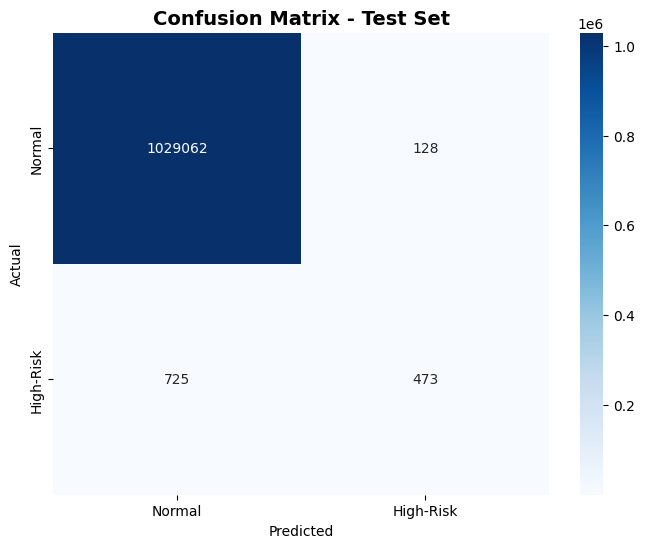

In [47]:
# Confusion Matrix
cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'High-Risk'],
            yticklabels=['Normal', 'High-Risk'])
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

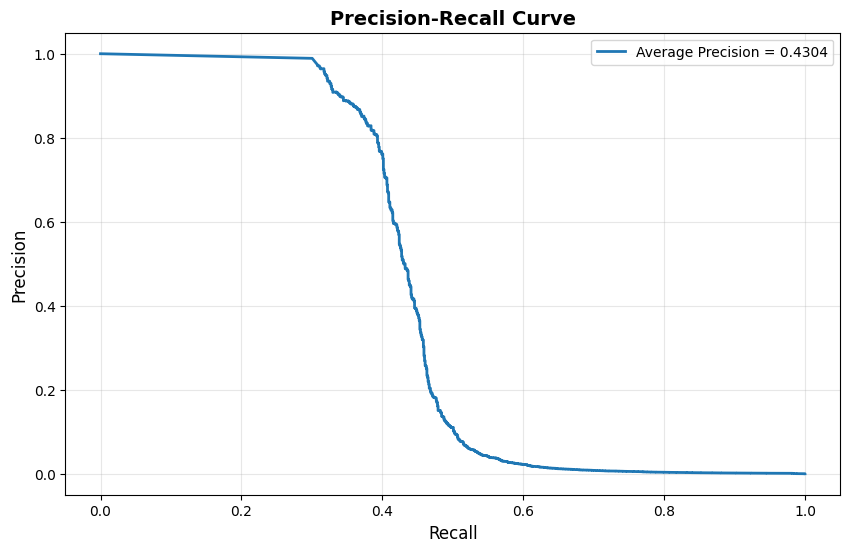

In [48]:
# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, preds_proba)
test_auc = auc(recall, precision)
avg_prec = average_precision_score(y_test, preds_proba)


plt.figure(figsize=(10, 6))
plt.plot(recall, precision, linewidth=2, label=f'Average Precision = {avg_prec:.4f}')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

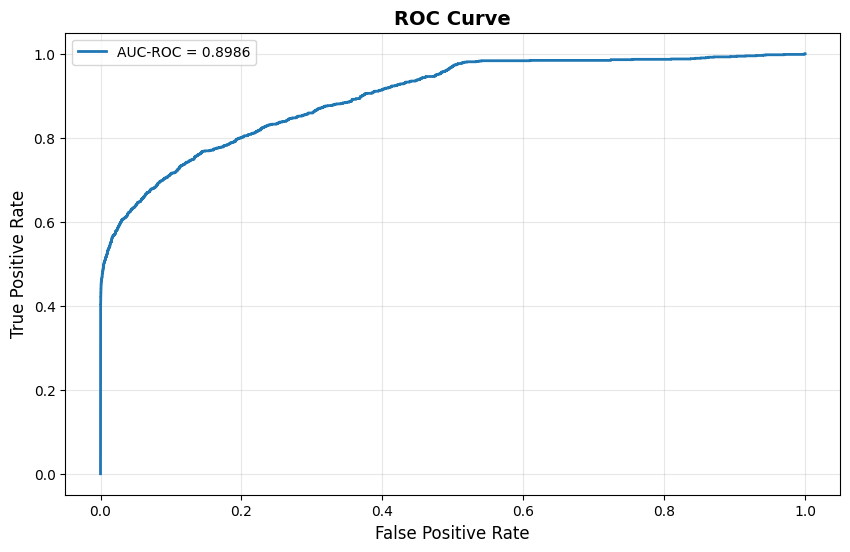

In [49]:
# True Positve Rate - False Positive Rate
fpr, tpr, thresholds = roc_curve(y_test, preds_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'AUC-ROC = {roc_auc:.4f}')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [50]:
preds

array([0, 0, 0, ..., 0, 0, 0])

In [51]:
report_dict = classification_report(y_test, preds, output_dict=True)
report_df = pd.DataFrame(report_dict)
report_df

,0,1,accuracy,macro avg,weighted avg
precision,9.992960e-01,0.787022,0.999172,8.931588e-01,9.990492e-01
recall,9.998756e-01,0.394825,0.999172,6.973502e-01,9.991722e-01
f1-score,9.995857e-01,0.525848,0.999172,7.627167e-01,9.990349e-01
support,1.029190e+06,1198.000000,0.999172,1.030388e+06,1.030388e+06


**Shap**

In [52]:
import shap

In [53]:
explainer = shap.TreeExplainer(final_model)

In [54]:
shap_values = explainer.shap_values(X_test)
expected_value = explainer.expected_value

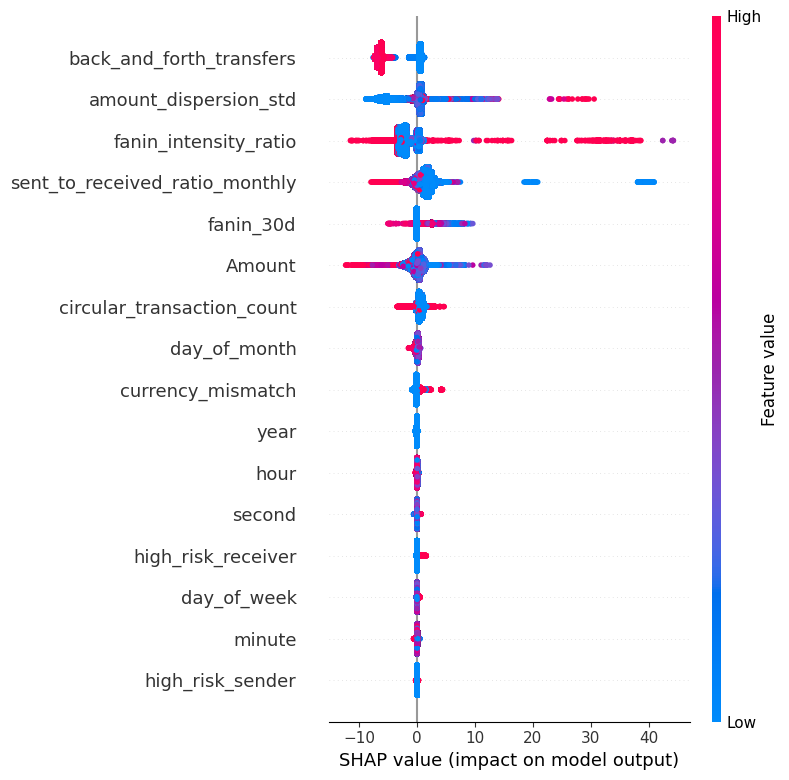

In [55]:
shap.summary_plot(shap_values, X_test, feature_names=opt_features[:-1])